In [3]:
from tensorflow.keras import layers, models
import tensorflow as tf
import keras
import os
import numpy as np
import pandas as pd
import cv2
import matplotlib.pyplot as plt
from keras.callbacks import TensorBoard
from time import time

In [4]:
TRAIN_PATH = './images-fresh-Shaima-CNN/train'
TEST_PATH = './images-fresh-Shaima-CNN/test'
CLASS_NAMES = ["hello", "help", "iloveyou", "no", "yes"]
BATCH_SIZE = 4
print(os.listdir(TRAIN_PATH))

['no', 'hello', 'yes', 'iloveyou', 'help']


Preprocessing Images

In [5]:
image_size = (180, 180)

train_dataset = tf.keras.utils.image_dataset_from_directory(
    TRAIN_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=BATCH_SIZE,
)

# Create test dataset
test_dataset = tf.keras.utils.image_dataset_from_directory(
    TEST_PATH,
    label_mode='categorical',
    color_mode='grayscale',
    image_size=image_size,
    batch_size=BATCH_SIZE,    
)

print("Datasets created successfully.")

Found 39 files belonging to 5 classes.
Found 10 files belonging to 5 classes.
Datasets created successfully.


Taking the validation set from train set

In [6]:
train_size = int(len(train_dataset)*.8)
val_size = int(len(train_dataset)*.2)

In [7]:
#Split the data
train = train_dataset.take(train_size)
val = train_dataset.skip(train_size).take(val_size)

In [9]:
for images, labels in train_dataset.take(1):
    print(labels)

tf.Tensor(
[[0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]], shape=(4, 5), dtype=float32)


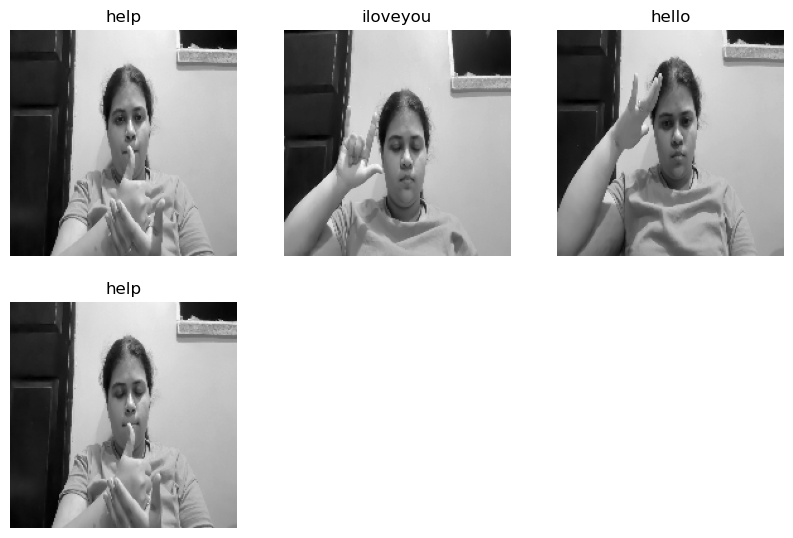

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train.take(1):  # Assuming you want to visualize from the train_dataset
    for i in range(4):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze().astype("uint8"), cmap='gray')  # Squeeze to remove the single-channel dimension
        plt.title(CLASS_NAMES[tf.argmax(labels[i]).numpy()])  # Assuming labels are one-hot encoded
        plt.axis("off")
plt.show()


Model Creation


In [11]:
# Define input shape
image_height, image_width = 180, 180
num_classes = 5

# Define the CNN model
# model = tf.keras.models.Sequential([
#     tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_height, image_width, 1)),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
#     tf.keras.layers.MaxPooling2D(2, 2),
#     tf.keras.layers.Flatten(),
#     tf.keras.layers.Dense(128, activation='relu'),
#     tf.keras.layers.Dropout(0.5),
#     tf.keras.layers.Dense(num_classes, activation='softmax')
# ])

model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_height, image_width, 1)),
    layers.Conv2D(16, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 1, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(num_classes, activation='softmax')
])

In [12]:
# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Print the model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 1)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      32        
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        544       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        2

In [14]:
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

Run `tensorboard --logdir=logs/` in a terminal before fitting

In [15]:
# Fit the model 
epochs = 10
history = model.fit(
    train,
    batch_size=BATCH_SIZE,
    validation_data=val,
    epochs=epochs,
    callbacks = [tensorboard]
)

Epoch 1/10
8/8 [==============================] - 1s 40ms/step - loss: 1.8326 - accuracy: 0.1875 - val_loss: 1.4830 - val_accuracy: 0.5714
Epoch 2/10
8/8 [==============================] - 0s 25ms/step - loss: 1.5596 - accuracy: 0.2500 - val_loss: 1.5730 - val_accuracy: 0.2857
Epoch 3/10
8/8 [==============================] - 0s 24ms/step - loss: 1.4532 - accuracy: 0.3750 - val_loss: 1.4210 - val_accuracy: 0.5714
Epoch 4/10
8/8 [==============================] - 0s 22ms/step - loss: 1.3733 - accuracy: 0.6875 - val_loss: 1.1840 - val_accuracy: 0.8571
Epoch 5/10
8/8 [==============================] - 0s 21ms/step - loss: 1.1697 - accuracy: 0.5938 - val_loss: 0.9524 - val_accuracy: 0.5714
Epoch 6/10
8/8 [==============================] - 0s 22ms/step - loss: 0.9311 - accuracy: 0.7188 - val_loss: 0.6711 - val_accuracy: 1.0000
Epoch 7/10
8/8 [==============================] - 0s 22ms/step - loss: 0.5933 - accuracy: 0.9062 - val_loss: 0.4791 - val_accuracy: 0.8571
Epoch 8/10
8/8 [===========

In [16]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {test_accuracy}")
print("Test Accuracy:", test_accuracy)

print("Model trained and evaluated successfully.")

3/3 [==============================] - 0s 3ms/step - loss: 0.2038 - accuracy: 1.0000
Test accuracy: 1.0
Test Accuracy: 1.0
Model trained and evaluated successfully.


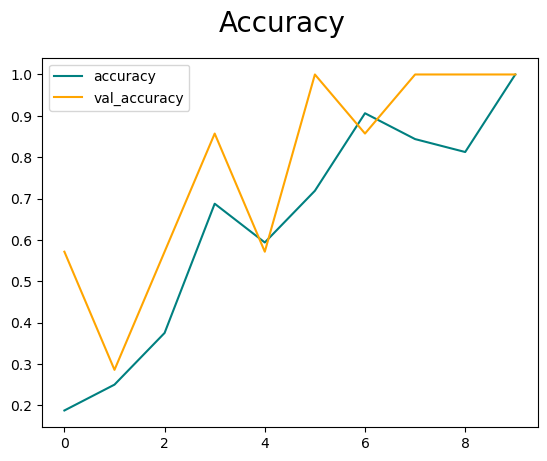

In [24]:
fig = plt.figure()
plt.plot(history.history['accuracy'], color='teal', label='accuracy')
plt.plot(history.history['val_accuracy'], color='orange', label='val_accuracy')
fig.suptitle('Accuracy', fontsize=20)
plt.legend(loc="upper left")
plt.show()

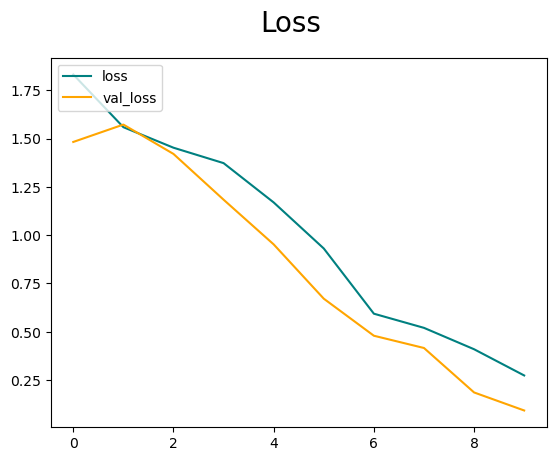

In [25]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

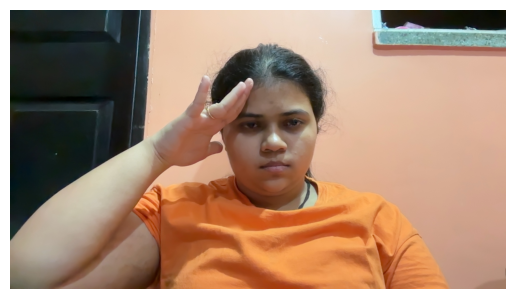

In [18]:
import numpy as np
import matplotlib.pyplot as plt

test_image_path = './images-fresh-Shaima-CNN/test/hello/hello.0715ec40-03c2-11ef-a8a4-7e09ada021c9.jpg'
# Load the test image
test_image = plt.imread(test_image_path)

# Display the test image
plt.imshow(test_image)
plt.axis('off')
plt.show()

In [19]:
# Resize the test image if necessary (assuming 'image_size' is the desired size)
image_size=[180, 180]
if test_image.shape[:2] != image_size:
    test_image = tf.image.resize(test_image, image_size)
# Convert the resized image to grayscale
test_image_gray = tf.image.rgb_to_grayscale(test_image)
test_image_gray = tf.expand_dims(test_image_gray, axis=0)  # Add batch dimension


In [20]:
# Predict the class of the test image using the trained model
predictions = model.predict(test_image_gray)

# Convert predictions to numpy array
predictions = np.array(predictions)

1/1 [==============================] - 0s 60ms/step


In [21]:
predictions

array([[9.8467535e-01, 3.0830733e-03, 1.0872816e-02, 8.0937840e-04,
        5.5926968e-04]], dtype=float32)

In [22]:
# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)

# Output the predicted class label 
predicted_class_label = CLASS_NAMES[predicted_class_index]
print("Predicted class is:", predicted_class_label)

Predicted class index: 0
Predicted class is: hello


In [38]:
model.save('cnn_Shaima-test-1.h5')

/Users/shaimahaque/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [39]:
model.save('cnn_Shaima-test-1.keras')